# Problem Set 1 - KNN
## CSCI 5622 - Spring 2020

For today's assignment, we will be implementing our own K-Nearest Neighbors (KNN) algorithm.

*But Professor Quigley, hasn't someone else already written KNN before?*

Yes, you are not the first to implement KNN, or basically any algorithm we'll work with in this class. But
1. I'll know that you know what's really going on
2. You'll know you can do it, because
    1. someday you might have to implement some machine learning algorithm from scratch - maybe for a new platform (do you need to run python on your SmartToaster just to get it to learn how users like their toast?), maybe because you want to tweak the algorithm (there's always a better approach...),
    2. maybe because you're working on something important, and you need to control exactly what's on there (should you really be running anaconda on your secret spy plane?).

That said - we're not going to implement *everything*. We'll start by importing a few helper functions

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn.datasets
import sklearn.neighbors
import sklearn.datasets
from collections import Counter

*Wait a minute - didn't we just import Scikit-learn (sklearn)? The package with baked-in machine learning tools?*

Yes - but it also has a ton of helper functions, including a dataset we'll be using later. But first, let's also create a dataset to play with and start working to build out our own classifier.

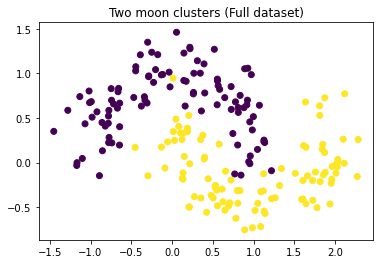

In [2]:
X, y = sklearn.datasets.make_moons(n_samples=200, noise=0.19, random_state=42)
X_train, y_train = X[:100], y[:100]
X_test, y_test = X[100:], y[100:]
plt.title("Two moon clusters (Full dataset)")
plt.scatter(X[:,0], X[:,1], c=y)
plt.show()

We have data!

Now, let's set up a KNNClassifier class. 

The KNNClassifier class will have similar design to the K-Nearest Neighbors classifier class from *scikit-learn*:
- Initialize the classifier with corresponding parameters (number of neighbors k)
- Fit the classifier using the training data
- Predict the class of new points `X_test`

We've written out a lot of the structure for you so it will be consistent and we can use / reuse it, and you can focus on the "important" stuff that actually relates to the machine learning itself.

In [3]:
class KNNClassifier:

    def __init__(self, k = 5):
        """
        Initialize our custom KNN classifier
        PARAMETERS

        k - the number of nearest neighbors to consider for classification
        """
        self._k = k
        self._model = None
        self._y = None
        self.label_to_index = None
        self.index_to_label = None
        self.counts = 0

    def fit(self, features, labels):
        """
        
        :param features: 2-D np.array of shape (number training samples, features dimension)
        :param labels: 1-D np.array of shape (number training samples,)
        :return: self
        """
        
        self._model = sklearn.neighbors.BallTree(features)
        self._y = labels
        self.counts = self.get_counts()
        # Should be used to map the classes to {0,1,..C-1} where C is the number of classes
        self.label_to_index = {zip(sorted(self.counts.keys()), range(len(self.counts)))}
        self.index_to_label = {zip(range(len(self.counts)), sorted(self.counts.keys()))}
        return self

    def get_counts(self):
        """
        Creates a dictionary storing the count of elements of each class
        :return: dict where the keys are the classes and values are the counts
        """

        counts = {}
        #BEGIN Workspace 1.1
        #TODO: Modify and/or add to counts so that it returns a count of each answer class found in y
        for label in self._y:
            if label in counts.keys():
                counts[label] += 1
            else:
                counts[label] = 1
        #END Workspace 1.1
        return counts

    def majority_vote(self, indices):
        """
        Given indices, report the majority label of those points.
        FOR A TIE, report the most common label in the data set.
        :param indices: indices of training neighbors of shape (M, k) where k is the classifier parameter
        :return: The majority label for each set of indices, shape (M,)
        """
        
        #BEGIN Workspace 1.2
        # TODO: Determine majority, assign it to label
        shape = np.shape(indices)
        labels = [None] * shape[0]
                
        def majority_vote_row(row):
            row_labels = [self._y[element] for element in row]
            counts = Counter(row_labels)
            max_val = max(counts.values())
            most_common_labels = [key for key, val in counts.items() if val == max_val]
            if len(most_common_labels) > 1:
                label = max(self.counts, key=self.counts.get)
            else:
                label = most_common_labels[0]
                
            return label
        
        labels = np.apply_along_axis(majority_vote_row, axis=1, arr=indices)
        
        #END Workspace 1.2
        return labels

    def predict(self, points):
        """
        Given new data points, classify them according to the training data provided in fit and number of neighbors k
        :param points: feature vectors of shape (num_points, num_features)
        :return: 1-D np.array of predicted classes of shape (num_points,)
        """
        
        #BEGIN Workspace 1.3
        #TODO: perform classification of points here
        #HINT: use the majority function created above
        #HINT: use the euclidean distance discussed in lecture to find nearest neighbors
        neighbor_indices = self._model.query(points, self._k, return_distance=False)
        neighbor_labels = self.majority_vote(neighbor_indices)
        
        #END Workspace 1.3
        return neighbor_labels

    def confusion_matrix(self, features_test, labels_test):
        """
        Generate the confusion matrix for the given test data
        :param features_test: an np.array of feature vectors of test points, shape (N, n_features)
        :param labels_test: he corresponding correct classes of our test set, shape (N,)
        :return: an C*C np.array of counts, where C is the number of classes in our classifier
        """
        C = len(np.unique(labels_test))
        c_matrix = np.zeros((C, C))
        
        #BEGIN Workspace 1.4
        #TODO: Run classification for the test set, compare to test answers, and add counts to matrix
        predictions = self.predict(features_test)

        for i in range(len(labels_test)):
            c_matrix[labels_test[i]][predictions[i]] += 1

        #END Workspace 1.4
        return c_matrix

    def accuracy(self, features_test, labels_test):
        """
        Generate an accuracy score for the classifier based on the confusion matrix
        PARAMETERS
        C - an np.array of counts
        RETURN
        score - an accuracy score
        """
        # score = 0
        #BEGIN Workspace 1.5
        #TODO: Compute accuracy of the classification of X_test
        C = self.confusion_matrix(features_test, labels_test)
        
        total = np.sum(C)
        true = 0
        for i in range(len(C)):
            true += C[i][i]
        
        score = true/total
        
        #END Workspace 1.5
        return score
    
    @staticmethod
    def display_confusion(c_matrix):
        fig, ax = plt.subplots()
        ax.matshow(c_matrix, cmap=plt.cm.Blues)
        for i in range(c_matrix.shape[0]):
            for j in range(c_matrix.shape[0]):
                ax.text(i, j, str(c_matrix[j,i]), va='center', ha='center')
        plt.show()

*But professor, this code isn't complete!*

### Problem 1: Complete our KNN Classifier - 25 Points

1.1 - Complete the `get_counts` function to return the count of each class found in the training set (5 points)

1.2 - Complete the `majority_vote` function to determine the majority class of a series of neighbors (5 points)

1.3 - Complete the `predict` function to capture the predicted class of a new datapoint (5 points)

 - HINT: Use the BallTree documentation to determine how to retrieve neighbors from the model (https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.BallTree.html#sklearn.neighbors.BallTree)

1.4 - Complete the `confusion_matrix` function to reveal the results of classification (5 points)

1.5 - Complete the `accuracy` function to get accuracy of the classifier based on a given test data (5 points)

Below, we'll be using our KNNClassifier (sent in as "model") to show how we would predict any points in space given the input data.

In [4]:
def show_decision_surface(model):
    """
    Helper function to visualize the decision surface of model
    :param model: Initialized KNNClassifier
    :return: None
    """
    x_min, x_max = X[:, 0].min()-1, X[:, 0].max()+1
    y_min, y_max = X[:, 1].min()-1, X[:, 1].max()+1
    x_grid = np.arange(x_min, x_max, 0.1)
    y_grid = np.arange(y_min, y_max, 0.1)
    xx, yy = np.meshgrid(x_grid, y_grid)
    r1, r2 = xx.reshape(-1,1), yy.reshape(-1,1)
    grid = np.hstack((r1,r2))
    y_hat = model.predict(grid)
    zz = y_hat.reshape(xx.shape)
    plt.contourf(xx, yy, zz, cmap='PiYG')
    plt.scatter(X[:,0], X[:,1], c=y)
    plt.show()

1.6. Try different values of k and report their accuracies and confusion matrices on the test set. Make sure to keep `random_state=42` so that the reported values don't change when code is re-run (5 points)

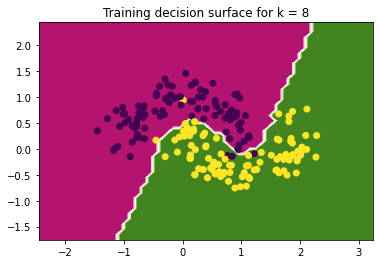

In [5]:
#BEGIN Workspace 1.6
#TODO: Try different Ks        
kk = 8
model = KNNClassifier(k=kk)
model = model.fit(X_train, y_train)
plt.title("Training decision surface for k = {}".format(kk))
show_decision_surface(model)
#END Workspace 1.6

k value: 10


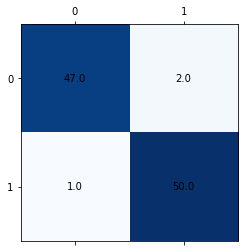

k value: 20


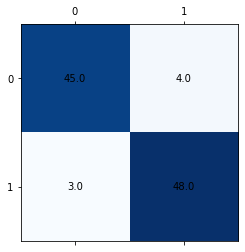

k value: 30


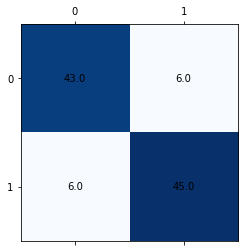

k value: 40


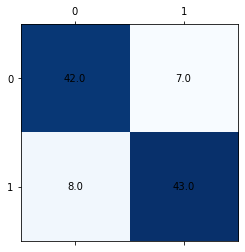

k value: 50


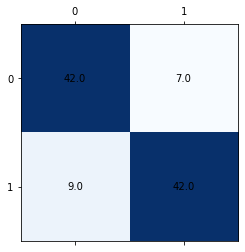

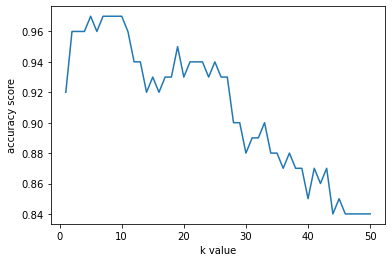

In [6]:
# Code for 1.6
d = {}

for k in range(1, 51):
    model = KNNClassifier(k=k)
    model = model.fit(X_train, y_train)
    c_matrix = model.confusion_matrix(X_test, y_test)
    accuracy = model.accuracy(X_test, y_test)
    d[k] = accuracy
    if k % 10 == 0:
        print("k value:", k)
        model.display_confusion(c_matrix)

x, y = zip(*d.items())
plt.plot(x, y)
plt.xlabel('k value')
plt.ylabel('accuracy score')
plt.show()

#### Write up for 1.6 here

As I increased the value of $k$, I found that the accuracy score trended downward (after a slight uptick at the beginning). This is because using only 1 or 2 neighbors doesn't give a great amout of information to classify the current point, and looking at more and more neighbors (and therefore valuing the classifications of points that are farther and farther away) can lead us astray in the classification process (points that are farther away are less likely to be significantly important, so counting them can mess with the accuracy of our classification). The "sweet spot" for k value seems to be between 5 and 10.

### Bonus (for the avid machine learner) (5 Points)
1.7. For which value of $k$ is the classifier consistent? (Only worry about this question within our `random_state=42` constraint)

1.8. Edit your `KNNClassifier` so that it's consistent for all $k$ (This solution should work beyond our `random_state=42` constraint, but retain the constraint when submitting your code above)

For a definition of a consistent classifier, refer to [Consistent Classification, Firm and Soft by Barum](https://proceedings.neurips.cc/paper/1996/file/7bb060764a818184ebb1cc0d43d382aa-Paper.pdf) (The answer is found in the abstract and introduction sections of the paper) 

#### Write up for the bonus

***
OK - now we've demonstrated that our KNN classifier works, let's think about our problem space! 

## Our Dataset - Identifying Digits from Images

It's a pretty common problem - just imagine working at the post office, and you're handed a hand-written check,
and you have to identify exactly what it says.
Did they pay 500 or 600 dollars? Is the letter going to 80309 (campus) or 30309 (Atlanta)?

Let's be a little smart about this - let's up some classes and helper functions to help us out.

### Problem 2: Implement KNN on Digits dataset - 25 Points

2.1 **Randomly** divide our digit dataset into training and testing sets (10 Points)

2.2 Report the number of examples in training and testing, as well as measuring then number of pixels in each image (5 points)

2.3 Create a confusion matrix of our classifier for K = 5 (10 points) *HINT: Doing this may cause you to catch mistakes in your classifier. Go fix those!*

In [7]:
class Numbers:
    def __init__(self, k = 5):
        #load data from sklearn
        
        data = sklearn.datasets.load_digits()
        features = data["data"]
        self.labels = data["target"]
        self.features = features.reshape(features.shape[0], -1)
        
        # BEGIN Workspace 2.1
        assert (len(self.labels) == len(self.features))
        shuffled_order = np.random.permutation(len(self.labels))
        shuffled_features = self.features[shuffled_order]
        shuffled_labels = self.labels[shuffled_order]
        
        split_point = int(len(self.labels)*.8)
        
        self.train_x = shuffled_features[:split_point] # A 2D np.array of training examples, REPLACE
        self.train_y = shuffled_labels[:split_point] # A 1D np.array of training answers, REPLACE
        self.test_x = shuffled_features[split_point:] # A 2D np.array of testing examples, REPLACE
        self.test_y = shuffled_labels[split_point:] # A 1D np.array of testing answers, REPLACE
        self.classifier = KNNClassifier(k=k) # KNNClassifier, REPLACE
        
        # TODO: - Divide our dataset into Train and Test datasets (80/20 split),
        #        replacing the variables above
        #       - Initialize the classifier
        #END Workspace 2.1
        
    def report(self):
        """
        Report information about the dataset using the print() function
        """
        #BEGIN Workspace 2.2
        #TODO: Create printouts for reporting the size of each set and the size of each datapoint
        print("Size of training set:", len(self.train_x))
        print("Size of testing set:", len(self.test_x))
        print("Number of pixels in each image:", np.shape(self.test_x)[1])
        
        #END Workspace 2.2
        

    def classify(self):
        """
        Fits classifier using the training data and generate a confusion matrix for the test data
        then return the confusion matrix
        """
        #BEGIN Workspace 2.3.a
        #TODO: Create classifier from training data, generate confusion matrix for test data
        self.classifier = self.classifier.fit(self.train_x, self.train_y)
        
        c_matrix = self.classifier.confusion_matrix(self.test_x, self.test_y)
        
        #END Workspace 2.3.a

        return  c_matrix
        
    
    
    def accuracy(self):
        c_matrix = self.classify()
        accuracy = 0
        #BEGIN Workspace 2.3.b
        #TODO: Compute accuracy using confusion matrix
        accuracy = self.classifier.accuracy(self.test_x, self.test_y)
        
        #END Workspace 2.3.b
        
        return accuracy

    def view_digit(self, index):
        """
        Display an image of a digit
        PARAMETERS
        digitImage - a data object from the dataset
        """
        #TODO: process digit_image to matrix "image"
        digit_image = self.features[index]
        image = digit_image.reshape(8, -1)
        print("Image for digit {}".format(self.labels[index]))
        plt.matshow(image)
        plt.show()
    
    @staticmethod
    def display_confusion(c_matrix):
        fig, ax = plt.subplots()
        ax.matshow(c_matrix, cmap=plt.cm.Blues)
        for i in range(c_matrix.shape[0]):
            for j in range(c_matrix.shape[0]):
                ax.text(i, j, str(c_matrix[j,i]), va='center', ha='center')
        plt.show()

Size of training set: 1437
Size of testing set: 360
Number of pixels in each image: 64
Image for digit 0


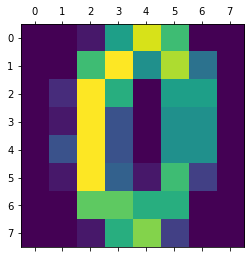

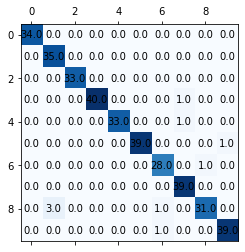

In [8]:
numbers = Numbers()
numbers.report()
numbers.view_digit(10)
numbers.display_confusion(numbers.classify())

*Wow, I can't believe we just created a KNN Classifier for multiple classes - but can't we make it better?*

Yes, we saw above that our classifier didn't work perfectly. Let's explore that issue a little further by turning the $K$ and random split knobs

### Problem 3: Improving KNN on Digits - 20 Points

3.1 Determine which classes are most often confused (from our confusion matrix above), inspect some examples of these digits (using the `view_digit` function in our Numbers class), and write a brief (4 - 5 sentences) description of why you think these particular numbers may be misclassified. (10 pts)

3.2 Explore the influence of the number of nearest neighbors (i.e. try changing our K). Plot the relationship between K and accuracy, and write a brief (4 - 5 sentences) description of how this factor impacts our accuracy. To mitigate the effect of randomness from the split, you have to run the evaluation multiple times and report the mean accuracy. Make sure the runs for different Ks are done on the same splits. (5 pts)

3.3 Explore the influence of the train / test split of our data (i.e. copy our Numbers class into Numbers2 below and try changing the split for our dataset). Plot the relationship between the split % and accuracy, and write a brief (4 - 5 sentences) description of its impact. (5 pts)

You can complete the `NumbersKnobs` class and use it as you see fit. But it's only necessary for 3.3

Image for digit 1


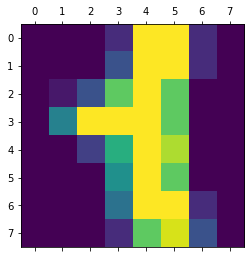

Image for digit 7


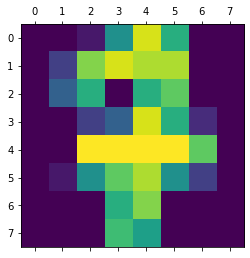

Image for digit 7


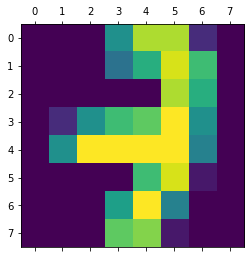

Image for digit 3


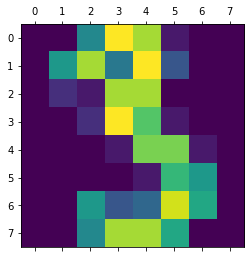

Image for digit 3


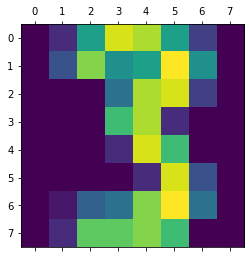

Image for digit 3


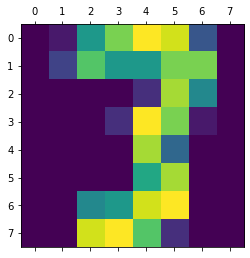

Image for digit 5


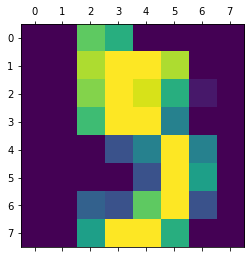

Image for digit 8


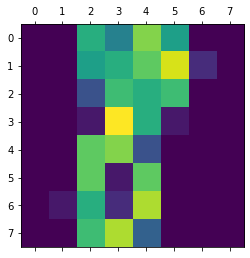

Image for digit 8


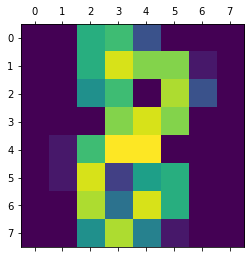

In [9]:
#BEGIN 3.1a
#TODO: Print out problem class images
for i in [21, 17, 27, 3, 13, 23, 5, 18, 28]:
    numbers.view_digit(i)

#END 3.1a

#### 3.1b
While the classification was a bit more accurate than I expected, I did notice some trends upon many runs, as well as when manually inspecting the images. The digits 3, 5, and 8 were often confused, likely because they have similar general shaping (stacked curves). The digits 1 and 7 were also confused on a somewhat often basis, likely because they also have similar general shaping (a relatively vertical line with an protrusion to the left near the top). The 1 vs. 7 confusion also depends a bit on how each digit is "drawn", as 1 can be drawn by simply making a vertical line, but is sometimes drawn with a protrusion to the left at the top of the vertical line. Additionally, any digits drawn in a very slim fashion were sometimes confused for a 1, as they look vaguely similar to a vertical line-based digit.

In [10]:
#BEGIN 3.2a
#TODO: Run evaluation for different K and plot K vs Accuracy
acc_dict = {}
for k in range(1, 51):
    print(k, end=', ')
    acc = 0
    for l in range(10):
        numbers = Numbers(k = k)
        acc += numbers.accuracy()
    acc_dict[k] = acc / 10
#END 3.2a

1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 

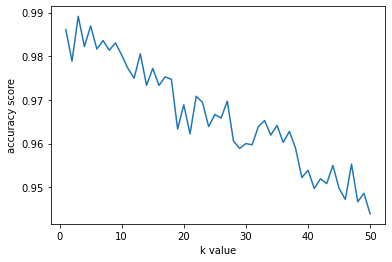

In [11]:
x, y = zip(*acc_dict.items())
plt.plot(x, y)
plt.xlabel('k value')
plt.ylabel('accuracy score')
plt.show()

#### 3.2b
As was also seen in the previous $k$ vs. accuracy plot, as the value of $k$ increases, the accuracy score generally trends downward. This is because looking at more and more neighbors and therefore equally valuing the classifications of points that are farther and farther away can lead us astray in the classification process (points that are farther away are less likely to be significantly important to the current point, so counting them as equal can mess with the accuracy of our classification).

In [12]:

class NumbersKnobs(Numbers):
    """ Inherits from Numbers, so feel free to use methods from Numbers
    """

    def __init__(self, k=5, train_ratio=0.8):
        #load data from sklearn
        self._k = k
        self.train_ratio = train_ratio
        
        data = sklearn.datasets.load_digits()
        features = data["data"]
        labels = data["target"]
        features = features.reshape(features.shape[0], -1)

        #BEGIN Workspace 3.3a
        assert (len(labels) == len(features))
        shuffled_order = np.random.permutation(len(labels))
        shuffled_features = features[shuffled_order]
        shuffled_labels = labels[shuffled_order]
        
        split_point = int(len(labels)*self.train_ratio)
        
        self.train_x = shuffled_features[:split_point] # A 2D np.array of training examples, REPLACE
        self.train_y = shuffled_labels[:split_point] # A 1D np.array of training answers, REPLACE
        self.test_x = shuffled_features[split_point:] # A 2D np.array of testing examples, REPLACE
        self.test_y = shuffled_labels[split_point:] # A 1D np.array of testing answers, REPLACE
        self.classifier = KNNClassifier(k=k) # KNNClassifier, REPLACE
        
        # TODO: - Divide our dataset into Train and Test datasets (80/20 split),
        #        replacing the variables above
        #       - Initialize the classifier
        #TODO: Divide our dataset into Train and Test datasets (using trainPercentage), replacing the variables above
        #HINT: You should be able to mostly copy your own work from the original Numbers class
        #END Workspace 3.3a


0.5: 0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,
0.55: 0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,
0.6: 0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,
0.65: 0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,
0.7: 0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,
0.75: 0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,
0.8: 0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,

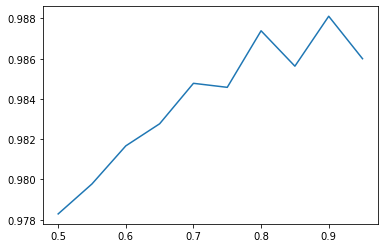

In [29]:
#BEGIN Workspace 3.3b
#TODO: analyze the effect of split ratio
k = 5
repetitions = 50 # Feel free to increase it
split_ratios = np.array([0.5, .55, 0.6, .65, 0.7, .75, .8, .85, .9, .95])
results = np.zeros((len(split_ratios),repetitions))
for i, s in enumerate(split_ratios):
    print(s ,end =": ")
    for j in range(repetitions):
        print(j, end=",")
        numbers = NumbersKnobs(k=k, train_ratio=s)
        results[i,j] = numbers.accuracy() # TODO get accuracy of classification
    print("")
# Add title axis labels to the plot
plt.plot(split_ratios, results.mean(1))

#END Workspace 3.3b

#### 3.3b
Increasing the split ratio shows a trending increase in accuracy. This is because training on more and more training data will typically allow the classifier to more and more accurately classify the testing data. However, it's important to consider what data the training set contains. Since we randomly shuffle the data each time before splitting it, then take the average of many splits over many runs, the trend should be one of increasing accuracy. Given any one run, however, using a high split ratio may lead to overfitting if the testing data happens to be "different" enough from the training data. Over many runs this effect shouldn't be prevalent, but is still important to consider.

### Problem 4 : Improving KNN on MNIST using WeightedKNN (30 pts)
Complete the `WeightedKNNClassifier` class to perform the weighted KNN classification.
The Weighted KNN classifier assigns weights to the nearest-neighbor training examples proportional to the inverse-distance from the training example to the query point. Classification is performed by summing the weights associated with each class and predicting the class with the highest weighted-majority vote. Mathematically we might describe the weighted-vote for a class $c$ as 

$$
\textrm{Weighted-Vote}(c)(x) = \sum_{i \in {\cal N}_K(x)} I(y_i \in c) \times \frac{1}{\|{\bf x}_i - {\bf x}\|}
$$
where ${\cal N}_K(x)$ is the set of the closest $k$ neighbors to $x$


4.1 Complete the `fit` method in a similar way to `KNNClassifier` (5 pts)

4.2 Complete `majority_vote`: it's certainly possible that a query point could be distance $0$ away from some training example. If this happens your implementation should handle it and return the appropriate class label. (5 pts)

4.3 Complete `predict` (5 pts)

4.4 Compete `confusion_matrix` and `accuracy` methods (5 pts)

4.5 Compare `KNNClassifier` and `WeightedKNNClassifier` for multiple $K$, make sure that for each run both classifers are fitted using the same train/test split. You can execute multiple runs to mitigate the split randomness. Report for which K you get the best accuracy for each classifier and the best overall classifier. (10 pts)


In [14]:
class WeightedKNNClassifier:
    """
    Class to store data for regression problems 
    """
    def __init__(self, k):
        """
        Creates a kNN instance
        :param k: The number of nearest points to consider in classification
        """
        
        # Import and build the BallTree on training features 
        self._k = k
        self._model = None
        self._y = None
        
        # Boolean flag indicating whether to do distance weighting (if you want to make it versatile)
        
    def fit(self, features, labels):
        
        # BEGIN Workspace 4.1
        self._model = sklearn.neighbors.BallTree(features)
        self._y = labels

        #END Workspace 4.1

        # Should be used to map set of classes to {0,1,..C-1} where C is the number of classes
        classes = list(set(list(labels)))
        self.label_to_index = dict(zip(sorted(classes), range(len(classes))))
        self.index_to_label = dict(zip(range(len(classes)), sorted(classes)))
        return self



    def majority_vote(self, neighbor_indices, neighbor_distances=None):
        """
        Given indices of nearest neighbors in training set, return the majority label. 
        Break ties by considering 1 fewer neighbor until a clear winner is found. 

        :param neighbor_indices: The indices of the K nearest neighbors in self.X_train 
        :param neighbor_distances: Corresponding distances from query point to K nearest neighbors. 
        """
        
        # YOUR CODE HERE
        #BEGIN Workspace 4.2
        shape = np.shape(neighbor_indices)
        labels = [None] * shape[0]
        
        for i in range(shape[0]):
            scores = {}
            for j in range(shape[1]):
                label = self._y[neighbor_indices[i][j]]
                distance = neighbor_distances[i][j]
                if label in scores.keys():
                    scores[label] += 1/distance
                else:
                    scores[label] = 1/distance
                    
            max_val = max(scores.values())
            most_common_labels = [key for key, val in scores.items() if val == max_val]
            if len(most_common_labels) > 1:
                label = get_scores(A[:-1])
            else:
                label = most_common_labels[0]
            
            labels[i] = label
        
        #END Workspace 4.2
        
        return labels
    
    def predict(self, features):
        """
        Given an np.array of query points, return y_hat, an np.array of predictions

        :param features: an (m x p) dimension np.array of points to predict labels for
        """
        
        # YOUR CODE HERE
        #BEGIN Workspace 4.3
        #TODO: predict labels
        neighbor_indices_distances = self._model.query(features, self._k, return_distance=True)
        neighbor_indices = neighbor_indices_distances[1]
        neighbor_distances = neighbor_indices_distances[0]
        neighbor_labels = self.majority_vote(neighbor_indices, neighbor_distances)
        
        #END Workspace 4.3
        return neighbor_labels
    
    def confusion_matrix(self, features_test, labels_test):
        """
        Generate a confusion matrix for the given test set
        PARAMETERS
        testX - an np.array of feature vectors of test points
        testY - the corresponding correct classifications of our test set
        RETURN
        C - an N*N np.array of counts, where N is the number of classes in our classifier
        """
        C = len(np.unique(labels_test))
        c_matrix = np.zeros((C, C))
        
        #BEGIN Workspace 4.4.a
        #TODO: Run classification for the test set, compare to test answers, and add counts to matrix
        predictions = self.predict(features_test)

        for i in range(len(labels_test)):
            c_matrix[labels_test[i]][predictions[i]] += 1
        
        #END Workspace 4.4.a
    
        return c_matrix
    
    def accuracy(self, features_test, labels_test):
        """
        Generate an accuracy score for the classifier based on the confusion matrix
        PARAMETERS
        C - an np.array of counts
        RETURN
        score - an accuracy score
        """
        score = 0
        #BEGIN Workspace 4.4.b
        #TODO: Compute accuracy of the classification of features_test
        C = self.confusion_matrix(features_test, labels_test)
        
        total = np.sum(C)
        true = 0
        for i in range(len(C)):
            true += C[i][i]
        
        score = true/total
        
        #END Workspace 4.4.b
        return score
    
    @staticmethod
    def display_confusion(c_matrix):
        fig, ax = plt.subplots()
        ax.matshow(c_matrix, cmap=plt.cm.Blues)
        for i in range(c_matrix.shape[0]):
            for j in range(c_matrix.shape[0]):
                ax.text(i, j, str(c_matrix[j,i]), va='center', ha='center')
        plt.show()

In [15]:
class NumbersWeighted(NumbersKnobs):
    def __init__(self, k=5, train_ratio=0.8):
        super(NumbersWeighted, self).__init__(k, train_ratio)
        self.classifier = WeightedKNNClassifier(k=self._k)
        

In [27]:
#BEGIN Workspace 4.5
#TODO: Run multiple comparisons
repetitions = 50
ks = range(1, 51) # Add more
results_simple = np.zeros((len(ks),repetitions))
results_weighted = np.zeros((len(ks),repetitions))

for i, k in enumerate(ks):
    print(k,end =": ")
    for j in range(repetitions):
        print(j, end=",")
        numbers = NumbersWeighted(k=k)
        results_weighted[i,j] = numbers.accuracy()
        numbers.classifier = KNNClassifier(k=numbers._k)
        results_simple[i,j] = numbers.accuracy()
    print("")

#TODO Average results over multiple runs and report best classifier

#END Workspace 4.5

1: 0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,
2: 0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,
3: 0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,
4: 0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,
5: 0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,
6: 0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,
7: 0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47

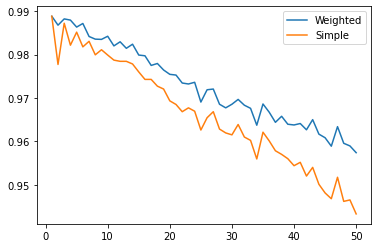

In [28]:
plt.plot(ks, results_weighted.mean(1), label='Weighted')
plt.plot(ks, results_simple.mean(1), label='Simple')
plt.legend()
plt.show()

#### 4.5
Across numerous runs, the results are about what I expected. The weighted version performs equal or better for all values of $k$. In regards to the best values of $k$, it differs a bit between weighted and unweighted. The weighted version typically has the best accuracy somewhere between 1 and 7, while the unweighted version seemed to always prefer the lowest end of the spectrum, around 1 - 3.

#### Bonus (5 Points)
__4.6 Is `WeightedKNNClassifier` a consistent classifier? why or why not?__

*4.6 bonus response here*